## Predikcia vsetkych parametrov pomocou jednej NN pre overcontact data

In [1]:
# LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from keras.utils import np_utils
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import Input, Dense, concatenate, Activation, LSTM, Dropout, Flatten
from keras.models import Model
from keras.layers.merge import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
np.random.seed(1234)
pd.set_option('display.max_rows', None)

In [4]:
def generate_observation_sigma(space_obs_frac=0.5):
    """
    Draws a standard deviation of noise in light curve points from a "true" value provided in synthetic light curve.
    Noise sigma is drawn from bimodal distribution taking into account contributions from space based and earth based
    observations which have different levels of stochastic noise.

    :param space_obs_frac: ratio between earth based and space based observations
    :return: float; standard deviation of the light curve noise
    """
    earth_based_sigma = 4e-3
    space_based_sigma = 2e-4
    sigma = np.random.choice([earth_based_sigma, space_based_sigma], p=[1-space_obs_frac, space_obs_frac])
    return np.random.rayleigh(sigma)

def stochastic_noise_generator(curve):
    """
    Introduces gaussian noise into synthetic observation provided in `curve`.

    :param curve: numpy.array; normalized light curve
    :return: Tuple(numpy.array, float); normalized light curve with added noise, standard deviation of observations
    """
    sigma = generate_observation_sigma()
    return np.random.normal(curve, sigma), np.full(curve.shape, sigma)

### Data loading

In [5]:
data = pd.read_pickle("overcontact_all_parameters.pkl").reset_index() 

In [6]:
data.head()

,index,id,curve,primary__t_eff,secondary__t_eff,inclination,mass_ratio,primary__surface_potential,secondary__surface_potential,t1/t2,filter,critical_surface_potential,primary__equivalent_radius,secondary__equivalent_radius,primary__filling_factor,secondary__filling_factor
0,0,5525038,"[0.9271109336686163, 0.9271335908185164, 0.927...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,Bessell_U,1.959104,0.585781,0.21126,0.169244,0.169244
1,1,5525038,"[0.9267426667358384, 0.9267640025030627, 0.926...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,Bessell_B,1.959104,0.585781,0.21126,0.169244,0.169244
2,2,5525038,"[0.9271736551553694, 0.927193188167849, 0.9272...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,Bessell_V,1.959104,0.585781,0.21126,0.169244,0.169244
3,3,5525038,"[0.9286697051715368, 0.9286879105609007, 0.928...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,Bessell_R,1.959104,0.585781,0.21126,0.169244,0.169244
4,4,5525038,"[0.9304596200748534, 0.9304764401089076, 0.930...",5500,5250,0.766994,0.1,1.948052,1.948052,1.047619,Bessell_I,1.959104,0.585781,0.21126,0.169244,0.169244


In [7]:
data_sample = data.sample(n=100000)

In [8]:
list(data_sample.columns)

['index',
 'id',
 'curve',
 'primary__t_eff',
 'secondary__t_eff',
 'inclination',
 'mass_ratio',
 'primary__surface_potential',
 'secondary__surface_potential',
 't1/t2',
 'filter',
 'critical_surface_potential',
 'primary__equivalent_radius',
 'secondary__equivalent_radius',
 'primary__filling_factor',
 'secondary__filling_factor']

### Train-test split

In [9]:
X = []
for row in data_sample["curve"]:
    X.append(row)
X=np.array(X)

In [10]:
X.shape

(100000, 400)

In [11]:
# Nepotrebujeme "primary__t_eff", "secondary__t_eff" - staci pomer tychto hodnot = t1/t2
y = np.array(data_sample[[
    "inclination",
    "mass_ratio",
    "primary__surface_potential",
    "secondary__surface_potential",
    "t1/t2",
    "critical_surface_potential",
    "primary__equivalent_radius",
    "secondary__equivalent_radius",
    "primary__filling_factor",
    "secondary__filling_factor"]])

In [12]:
y.shape

(100000, 10)

In [13]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
X_train = []
y_train = []
for i in range(len(X_train1)):
    for j in range(3):
        curve = stochastic_noise_generator(X_train1[i])
        X_train.append(curve[0])
        y_train.append(y_train1[i])
X_train = np.array(X_train)
y_train=np.array(y_train)

In [15]:
print("Number of records in dataset: ", len(data),
    "\nNumber of records in sample: ", len(X),
    "\nNumber of train data without noise: ", len(X_train1),
    "\nNumber of train data with noise: ", len(X_train),
    "\nNumber of test data without noise: ", len(X_test))

Number of records in dataset:  1212796 
Number of records in sample:  100000 
Number of train data without noise:  80000 
Number of train data with noise:  240000 
Number of test data without noise:  20000


## Model

In [ ]:
inputs = Input(shape=(400, 1))
b = Conv1D(64, kernel_size = 3, padding = "valid")(inputs)
b = MaxPooling1D(2)(b)
b = Dropout(0.2)(b)
b = LSTM(64, return_sequences=True)(b)
b = Flatten()(b)
b = Dense(64, activation='relu')(b)
x = Dense(32, activation='relu')(b)
output = Dense(10, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(model.summary())

In [ ]:
saved_model = "models/over_allParams.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor = 'val_mae', verbose = 1, save_best_only = True, mode = 'min')
early = EarlyStopping(monitor = "val_mae", mode = "min", patience = 25)
callbacks_list = [checkpoint, early]

In [ ]:
history = model.fit(X_train, y_train, validation_split = 0.1, epochs = 10, verbose = 1, callbacks = callbacks_list, batch_size = 64)

In [16]:
model = load_model("models/over_allParams.hdf5")

In [ ]:
#EVALUATED ON TEST DATA WITHOUT NOISE
model.evaluate(X_test, y_test)

In [17]:
# ADD NOISE TO TEST DATA
X_test_n = []
y_test_n = []
for i in range(len(X_test)):
    for j in range(3):
        curve = stochastic_noise_generator(X_test[i])
        X_test_n.append(curve[0])
        y_test_n.append(y_test[i])
        j += 1

In [18]:
X_test_n = np.array(X_test_n)
y_test_n = np.array(y_test_n)

In [19]:
# EVALUATED ON TEST DATA WITH NOISE
model.evaluate(X_test_n, y_test_n)

1875/1875 [==============================] - 98s 52ms/step - loss: 0.0611 - mean_absolute_error: 0.1208 - mean_absolute_percentage_error: 12.2287 38s - loss: 0.0635 - mean_absolute_error: 0.1213 - mean_absolute_percentage_error: 1 - ETA: 37s - loss: 0.0636  - ETA: 3s - loss: 0.0617 - mean_absolute_error: 0.1211 


[0.06108751520514488, 0.12077078223228455, 12.228681564331055]

### Prediction on synthetic test data - without noise

In [64]:
y_pred = model.predict(X_test)

In [21]:
y_pred[0]

array([1.0946805 , 4.7392707 , 8.533597  , 8.441549  , 1.0220819 ,
       8.673995  , 0.2785359 , 0.52232516, 0.44838762, 0.36494642],
      dtype=float32)

In [65]:
P_inclination = [i[0] for i in y_pred]
P_mass_ratio = [i[1] for i in y_pred]
P_prim__surface_potential = [i[2] for i in y_pred]
P_sec__surface_potential = [i[3] for i in y_pred]
P_t1_t2 = [i[4] for i in y_pred]
P_critical_surface_potential = [i[5] for i in y_pred]
P_primary_equivalent_radius = [i[6] for i in y_pred]
P_secondary_equivalent_radius = [i[7] for i in y_pred]
P_primary_filling_factor = [i[8] for i in y_pred]
P_secondary_filling_factor = [i[9] for i in y_pred]

In [66]:
P_inclination = np.reshape(P_inclination, len(P_inclination))
P_mass_ratio = np.reshape(P_mass_ratio, len(P_mass_ratio))
P_prim__surface_potential = np.reshape(P_prim__surface_potential, len(P_prim__surface_potential))
P_sec__surface_potential = np.reshape(P_sec__surface_potential, len(P_sec__surface_potential))
P_t1_t2 = np.reshape(P_t1_t2, len(P_t1_t2))
P_critical_surface_potential = np.reshape(P_critical_surface_potential, len(P_critical_surface_potential))
P_primary_equivalent_radius = np.reshape(P_primary_equivalent_radius, len(P_primary_equivalent_radius))
P_secondary_equivalent_radius = np.reshape(P_secondary_equivalent_radius, len(P_secondary_equivalent_radius))
P_primary_filling_factor = np.reshape(P_primary_filling_factor, len(P_primary_filling_factor))
P_secondary_filling_factor = np.reshape(P_secondary_filling_factor, len(P_secondary_filling_factor))


In [67]:
df = pd.DataFrame(data =
     {
    'inclination': [i[0] for i in y_test],
    'P_inclination': P_inclination,
    'inclination_abs_diff': abs([i[0] for i in y_test] - P_inclination),

    'mass_ratio': [i[1] for i in y_test],
    'P_mass_ratio': P_mass_ratio,
    'mass_ratio_abs_diff': abs([i[1] for i in y_test] - P_mass_ratio),

    'prim_surface_potential': [i[2] for i in y_test],
    'P_prim_surf_potential': P_prim__surface_potential,
    'prim_surf_potent_abs_diff': abs([i[2] for i in y_test] - P_prim__surface_potential),

    'sec_surface_potential': [i[3] for i in y_test],
    'P_sec_surf_potential': P_sec__surface_potential,
    'sec_surf_potent_abs_diff': abs([i[3] for i in y_test] - P_sec__surface_potential),

    't1_t2': [i[4] for i in y_test],
    'P_t1_t2': P_t1_t2,
    't1_t2_abs_diff': abs([i[4] for i in y_test] - P_t1_t2),

    'critical_surf_potential': [i[5] for i in y_test],
    'P_crit_surf_potential': P_critical_surface_potential,
    'crit_surf_potential_abs_diff': abs([i[5] for i in y_test] - P_critical_surface_potential),

    'prim_equi_radius': [i[6] for i in y_test],
    'P_prim_equi_radius': P_primary_equivalent_radius,
    'prim_equi_radius_abs_diff': abs([i[6] for i in y_test] - P_primary_equivalent_radius),

    'sec_equi_radius': [i[7] for i in y_test],
    'P_sec_equi_radius': P_secondary_equivalent_radius,
    'sec_equi_radius_abs_diff': abs([i[7] for i in y_test] - P_secondary_equivalent_radius),

    'prim_filling_factor': [i[8] for i in y_test],
    'P_prim_filling_factor': P_primary_filling_factor,
    'prim_filling_factor_abs_diff': abs([i[8] for i in y_test] - P_primary_filling_factor),

    'sec_filling_factor': [i[9] for i in y_test],
    'P_sec_filling_factor': P_secondary_filling_factor,
    'sec_filling_factor_abs_diff': abs([i[9] for i in y_test] - P_secondary_filling_factor)
    })


In [105]:
df.head()

,inclination,P_inclination,inclination_abs_diff,mass_ratio,P_mass_ratio,mass_ratio_abs_diff,prim_surface_potential,P_prim_surf_potential,prim_surf_potent_abs_diff,sec_surface_potential,...,prim_equi_radius_abs_diff,sec_equi_radius,P_sec_equi_radius,sec_equi_radius_abs_diff,prim_filling_factor,P_prim_filling_factor,prim_filling_factor_abs_diff,sec_filling_factor,P_sec_filling_factor,sec_filling_factor_abs_diff
0,0.935491,1.094681,0.159190,3.333333,4.739271,1.405937,7.007351,8.533597,1.526246,7.007351,...,0.006248,0.492100,0.522325,0.030226,0.074968,0.448388,0.373420,0.074968,0.364946,0.289979
1,0.927295,1.017328,0.090033,2.500000,3.622497,1.122497,5.854167,7.047381,1.193215,5.854167,...,0.005160,0.471755,0.509637,0.037882,0.149309,0.482214,0.332905,0.149309,0.460357,0.311047
2,1.485231,1.463987,0.021244,1.000000,0.916591,0.083409,3.600772,3.539768,0.061004,3.600772,...,0.002910,0.406935,0.389204,0.017730,0.274719,0.258317,0.016402,0.274719,0.258596,0.016123
3,0.902054,0.920394,0.018341,1.666667,1.334700,0.331967,4.410223,3.860328,0.549895,4.410223,...,0.050120,0.477260,0.479571,0.002310,0.618986,0.735310,0.116324,0.618986,0.743143,0.124157
4,1.462674,1.198251,0.264423,0.200000,0.128971,0.071029,2.214079,2.173163,0.040916,2.214079,...,0.003909,0.257956,0.292184,0.034228,0.146158,0.294052,0.147894,0.146158,0.300588,0.154430


In [ ]:
df.to_csv('all_params_predictions/2_OvercontactSynthetic_allParams_OneModel.csv', index=False)

In [26]:
df_copy = df.copy()

In [27]:
df_comp = df_copy.drop([
        'inclination_abs_diff',
        'mass_ratio_abs_diff',
        'prim_surf_potent_abs_diff',
        'sec_surf_potent_abs_diff',
        't1_t2_abs_diff',
        'crit_surf_potential_abs_diff',
        'prim_equi_radius_abs_diff',
        'sec_equi_radius_abs_diff',
        'prim_filling_factor_abs_diff',
        'sec_filling_factor_abs_diff'
        ], axis = 1)

In [28]:
df_comp.head()

,inclination,P_inclination,mass_ratio,P_mass_ratio,prim_surface_potential,P_prim_surf_potential,sec_surface_potential,P_sec_surf_potential,t1_t2,P_t1_t2,critical_surf_potential,P_crit_surf_potential,prim_equi_radius,P_prim_equi_radius,sec_equi_radius,P_sec_equi_radius,prim_filling_factor,P_prim_filling_factor,sec_filling_factor,P_sec_filling_factor
0,0.935491,1.094681,3.333333,4.739271,7.007351,8.533597,7.007351,8.441549,1.037037,1.022082,7.054097,8.673995,0.284784,0.278536,0.492100,0.522325,0.074968,0.448388,0.074968,0.364946
1,0.927295,1.017328,2.500000,3.622497,5.854167,7.047381,5.854167,7.028968,1.000000,1.030903,5.945240,7.331349,0.312934,0.318094,0.471755,0.509637,0.149309,0.482214,0.149309,0.460357
2,1.485231,1.463987,1.000000,0.916591,3.600772,3.539768,3.600772,3.511590,1.071429,1.062556,3.750000,3.637359,0.406935,0.404025,0.406935,0.389204,0.274719,0.258317,0.274719,0.258596
3,0.902054,0.920394,1.666667,1.334700,4.410223,3.860328,4.410223,3.863567,1.086957,1.036972,4.772403,4.303124,0.389905,0.440025,0.477260,0.479571,0.618986,0.735310,0.618986,0.743143
4,1.462674,1.198251,0.200000,0.128971,2.214079,2.173163,2.214079,2.176864,1.041667,1.064237,2.232728,2.212610,0.529977,0.526068,0.257956,0.292184,0.146158,0.294052,0.146158,0.300588


In [140]:
# Results - inclination
avg_true_inc = sum(df_comp.inclination)/len(y_test)
avg_pred_inc = sum(df_comp.P_inclination)/len(y_test)
print('Avg true inc %f' % avg_true_inc)
print('Avg pred inc %f' % avg_pred_inc)

Avg true inc 1.221348
Avg pred inc 1.193492


In [141]:
# Results - mass ratio
avg_true_mr = sum(df_comp.mass_ratio)/len(y_test)
avg_pred_mr = sum(df_comp.P_mass_ratio)/len(y_test)
print('Avg true mass ratio %f' % avg_true_mr)
print('Avg pred mass ratio %f' % avg_pred_mr)

Avg true mass ratio 1.412813
Avg pred mass ratio 1.417530


In [142]:
# Results - primary surface potential
avg_true_psp = sum(df_comp.prim_surface_potential)/len(y_test)
avg_pred_psp = sum(df_comp.P_prim_surf_potential)/len(y_test)
print('Avg true primary surface potential %f' % avg_true_psp)
print('Avg pred primary surface potential %f' % avg_pred_psp)

Avg true primary surface potential 3.972770
Avg pred primary surface potential 3.968599


In [143]:
# Results - secondary surface potential
avg_true_ssp = sum(df_comp.sec_surface_potential)/len(y_test)
avg_pred_ssp = sum(df_comp.P_sec_surf_potential)/len(y_test)
print('Avg true secondary surface potential %f' % avg_true_ssp)
print('Avg pred secondary surface potential %f' % avg_pred_ssp)

Avg true secondary surface potential 3.972770
Avg pred secondary surface potential 3.963105


In [144]:
# Results - temperature ratio
avg_true_tr = sum(df_comp.t1_t2)/len(y_test)
avg_pred_tr = sum(df_comp.P_t1_t2)/len(y_test)
print('Avg true temperature ratio %f' % avg_true_tr)
print('Avg pred temperature ratio %f' % avg_pred_tr)

Avg true temperature ratio 1.048076
Avg pred temperature ratio 1.046491


In [145]:
# Results - critical surface potential
avg_true_csp = sum(df_comp.critical_surf_potential)/len(y_test)
avg_pred_csp = sum(df_comp.P_crit_surf_potential)/len(y_test)
print('Avg true critical surface potential %f' % avg_true_csp)
print('Avg pred critical surface potential %f' % avg_pred_csp)

Avg true critical surface potential 4.286547
Avg pred critical surface potential 4.314012


In [146]:
# Results - primary equivalent radius
avg_true_per = sum(df_comp.prim_equi_radius)/len(y_test)
avg_pred_per = sum(df_comp.P_prim_equi_radius)/len(y_test)
print('Avg true primary equivalent radius %f' % avg_true_per)
print('Avg pred primary equivalent radius %f' % avg_pred_per)

Avg true primary equivalent radius 0.431312
Avg pred primary equivalent radius 0.440175


In [147]:
# Results - secondary equivalent radius
avg_true_ser = sum(df_comp.sec_equi_radius)/len(y_test)
avg_pred_ser = sum(df_comp.P_sec_equi_radius)/len(y_test)
print('Avg true secondary equivalent radius %f' % avg_true_ser)
print('Avg pred secondary equivalent radius %f' % avg_pred_ser)

Avg true secondary equivalent radius 0.446961
Avg pred secondary equivalent radius 0.450492


In [148]:
# Results - primary filling factor
avg_true_pff = sum(df_comp.prim_filling_factor)/len(y_test)
avg_pred_pff = sum(df_comp.P_prim_filling_factor)/len(y_test)
print('Avg true primary filling factor %f' % avg_true_pff)
print('Avg pred primary filling factor %f' % avg_pred_pff)

Avg true primary filling factor 0.615457
Avg pred primary filling factor 0.648980


In [149]:
# Results - secondary filling factor
avg_true_sff = sum(df_comp.sec_filling_factor)/len(y_test)
avg_pred_sff = sum(df_comp.P_sec_filling_factor)/len(y_test)
print('Avg true secondary filling factor %f' % avg_true_sff)
print('Avg pred secondary filling factor %f' % avg_pred_sff)

Avg true secondary filling factor 0.615457
Avg pred secondary filling factor 0.652366


In [154]:
avg_dict = {
    "true_inc": [avg_true_inc],
    "pred_inc": [avg_pred_inc],

    "true_mass_ratio": [avg_true_mr],
    "pred_mass_ratio": [avg_pred_mr],

    "true_prim_surf_potent": [avg_true_psp],
    "pred_surf_potent": [avg_pred_psp],

    "true_sec_surf_potent": [avg_true_ssp],
    "pred_sec_surf_potent": [avg_pred_ssp],

    "true_temp_ratio": [avg_true_tr],
    "pred_temp_ratio":[avg_pred_tr],

    "true_crit_surf_potent":[avg_true_csp],
    "pred_crit_sufr_potent":[avg_pred_csp],

    "true_prim_equi_radius":[avg_true_per],
    "pred_prim_equi_radius":[avg_pred_per],

    "true_sec_equi_radius": [avg_true_ser],
    "preed_sec_equi_radius":[avg_pred_ser],

    "true_prim_fill_factor":[avg_true_pff],
    "pred_prim_fill_factor":[avg_pred_pff],

    "true_sec_fill_factor": [avg_true_sff],
    "pred_sec_fill_factor": [avg_pred_sff]
    }
avg_df = pd.DataFrame.from_dict(avg_dict)

In [155]:
avg_df

,true_inc,pred_inc,true_mass_ratio,pred_mass_ratio,true_prim_surf_potent,pred_surf_potent,true_sec_surf_potent,pred_sec_surf_potent,true_temp_ratio,pred_temp_ratio,true_crit_surf_potent,pred_crit_sufr_potent,true_prim_equi_radius,pred_prim_equi_radius,true_sec_equi_radius,preed_sec_equi_radius,true_prim_fill_factor,pred_prim_fill_factor,true_sec_fill_factor,pred_sec_fill_factor
0,1.221348,1.193492,1.412813,1.41753,3.97277,3.968599,3.97277,3.963105,1.048076,1.046491,4.286547,4.314012,0.431312,0.440175,0.446961,0.450492,0.615457,0.64898,0.615457,0.652366


In [29]:
cols = [
    "inclination",
    "mass_ratio",
    "primary__surface_potential",
    "secondary__surface_potential",
    "t1_t2",
    "critical_surface_potential",
    "primary__equivalent_radius",
    "secondary__equivalent_radius",
    "primary__filling_factor",
    "secondary__filling_factor"]

In [30]:
idx = np.random.choice(np.arange(len(y_test)), 1, replace=False)
true_sample = y_test[idx]
pred_sample = y_pred[idx]

In [31]:
comp = pd.DataFrame(data={"true_values": true_sample.flatten(),
                        "predicted_values": pred_sample.flatten(),
                        "abs diff": abs(true_sample.flatten()-pred_sample.flatten()),
                        "relative diff %": (abs(true_sample.flatten()-pred_sample.flatten())/true_sample.flatten()) * 100})

In [32]:
comp

,true_values,predicted_values,abs diff,relative diff %
0,1.458632,1.259716,0.198916,13.637155
1,0.300000,0.414693,0.114693,38.231138
2,2.306671,2.457006,0.150334,6.517363
3,2.306671,2.509428,0.202757,8.790011
4,1.033333,1.075377,0.042044,4.068752
5,2.466229,2.795861,0.329632,13.365824
6,0.538518,0.530790,0.007728,1.435094
7,0.337164,0.403092,0.065928,19.553721
8,0.852955,0.776245,0.076709,8.993381
9,0.852955,0.796070,0.056884,6.669103


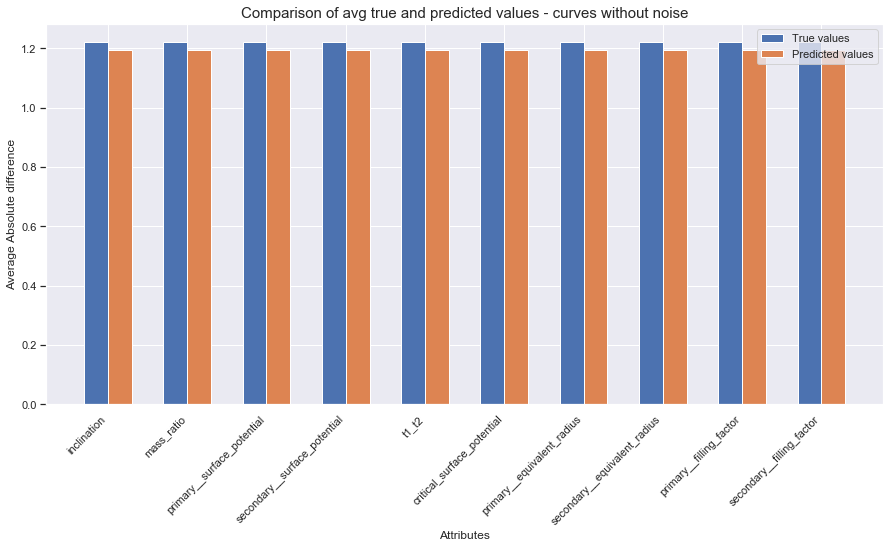

In [118]:
fig, ax = plt.subplots(figsize=(15,7))
x = np.arange(len(comp))
width = 0.3

plt.bar(x-0.15, sum(df_comp.inclination)/len(df_comp.inclination), width, label='True values')
plt.bar(x+0.15, sum(df_comp.P_inclination)/len(df_comp.inclination), width, label='Predicted values')

plt.title('Comparison of avg true and predicted values - curves without noise', fontsize=15)

plt.xticks(x, cols, rotation=45, ha='right')
ax.set_ylabel("Average Absolute difference")
ax.set_xlabel("Attributes")
ax.grid(False)
ax.tick_params(bottom=False, left=True)
plt.legend()
plt.grid(b="on")
plt.show()

In [ ]:
fig = plt.figure(figsize=(6, 4))

t = np.arange(-5.0, 1.0, 0.1)

sub1 = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
sub1.set_title('The function f') # non OOP: plt.title('The function f')
sub1.plot(t, f(t))


sub2 = fig.add_subplot(222, facecolor="lightgrey")
sub2.set_title('fp, the derivation of f')
sub2.plot(t, fp(t))


t = np.arange(-3.0, 2.0, 0.02)
sub3 = fig.add_subplot(223)
sub3.set_title('The function g')
sub3.plot(t, g(t))

t = np.arange(-0.2, 0.2, 0.001)
sub4 = fig.add_subplot(224, facecolor="lightgrey")
sub4.set_title('A closer look at g')
sub4.set_xticks([-0.2, -0.1, 0, 0.1, 0.2])
sub4.set_yticks([-0.15, -0.1, 0, 0.1, 0.15])
sub4.plot(t, g(t))

plt.plot(t, g(t))

plt.tight_layout()
plt.show()

### Prediction on synthetic test data - with  noise

In [ ]:
y_pred_n=model.predict(X_test_n)

In [ ]:
# P_prim__t_eff = [i[0] for i in y_pred]
# P_sec__t_eff = [i[1] for i in y_pred]
P_inclination = [i[0] for i in y_pred_n]
P_mass_ratio = [i[1] for i in y_pred_n]
P_prim__surface_potential = [i[2] for i in y_pred_n]
P_sec__surface_potential = [i[3] for i in y_pred_n]
P_t1_t2 = [i[4] for i in y_pred_n]
P_critical_surface_potential = [i[5] for i in y_pred_n]
P_primary_equivalent_radius = [i[6] for i in y_pred_n]
P_secondary_equivalent_radius = [i[7] for i in y_pred_n]
P_primary_filling_factor = [i[8] for i in y_pred_n]
P_secondary_filling_factor = [i[9] for i in y_pred_n]

In [ ]:
# P_prim__t_eff = np.reshape(P_prim__t_eff, len(P_prim__t_eff))
# P_sec__t_eff = np.reshape(P_sec__t_eff, len(P_sec__t_eff))
P_inclination = np.reshape(P_inclination, len(P_inclination))
P_mass_ratio = np.reshape(P_mass_ratio, len(P_mass_ratio))
P_prim__surface_potential = np.reshape(P_prim__surface_potential, len(P_prim__surface_potential))
P_sec__surface_potential = np.reshape(P_sec__surface_potential, len(P_sec__surface_potential))
P_t1_t2 = np.reshape(P_t1_t2, len(P_t1_t2))
P_critical_surface_potential = np.reshape(P_critical_surface_potential, len(P_critical_surface_potential))
P_primary_equivalent_radius = np.reshape(P_primary_equivalent_radius, len(P_primary_equivalent_radius))
P_secondary_equivalent_radius = np.reshape(P_secondary_equivalent_radius, len(P_secondary_equivalent_radius))
P_primary_filling_factor = np.reshape(P_primary_filling_factor, len(P_primary_filling_factor))
P_secondary_filling_factor = np.reshape(P_secondary_filling_factor, len(P_secondary_filling_factor))


In [ ]:
df = pd.DataFrame(data =
    {
    # 'primary__t_eff': [i[0] for i in y_test],
    # 'P_prim__t_eff': P_prim__t_eff,
    # 'prim_t_eff_abs_diff': abs([i[0] for i in y_test] - P_prim__t_eff),

    # 'secondary__t_eff': [i[1] for i in y_test],
    # 'P_sec__t_eff': P_sec__t_eff,
    # 'sec_t_eff_abs_diff': abs([i[1] for i in y_test] - P_sec__t_eff),

    'inclination': [i[0] for i in y_test_n],
    'P_inclination': P_inclination,
    'inclination_abs_diff': abs([i[0] for i in y_test_n] - P_inclination),

    'mass_ratio': [i[1] for i in y_test_n],
    'P_mass_ratio': P_mass_ratio,
    'mass_ratio_abs_diff': abs([i[1] for i in y_test_n] - P_mass_ratio),

    'prim_surface_potential': [i[2] for i in y_test_n],
    'P_prim_surf_potential': P_prim__surface_potential,
    'prim_surf_potent_abs_diff': abs([i[2] for i in y_test_n] - P_prim__surface_potential),

    'sec_surface_potential': [i[3] for i in y_test_n],
    'P_sec_surf_potential': P_sec__surface_potential,
    'sec_surf_potent_abs_diff': abs([i[3] for i in y_test_n] - P_sec__surface_potential),

    't1_t2': [i[4] for i in y_test_n],
    'P_t1_t2': P_t1_t2,
    't1_t2_abs_diff': abs([i[4] for i in y_test_n] - P_t1_t2),

    'critical_surf_potential': [i[5] for i in y_test_n],
    'P_crit_surf_potential': P_critical_surface_potential,
    'crit_surf_potential_abs_diff': abs([i[5] for i in y_test_n] - P_critical_surface_potential),

    'prim_equi_radius': [i[6] for i in y_test_n],
    'P_prim_equi_radius': P_primary_equivalent_radius,
    'prim_equi_radius_abs_diff': abs([i[6] for i in y_test_n] - P_primary_equivalent_radius),

    'sec_equi_radius': [i[7] for i in y_test_n],
    'P_sec_equi_radius': P_secondary_equivalent_radius,
    'sec_equi_radius_abs_diff': abs([i[7] for i in y_test_n] - P_secondary_equivalent_radius),

    'prim_filling_factor': [i[8] for i in y_test_n],
    'P_prim_filling_factor': P_primary_filling_factor,
    'prim_filling_factor_abs_diff': abs([i[8] for i in y_test_n] - P_primary_filling_factor),

    'sec_filling_factor': [i[9] for i in y_test_n],
    'P_sec_filling_factor': P_secondary_filling_factor,
    'sec_filling_factor_abs_diff': abs([i[9] for i in y_test_n] - P_secondary_filling_factor)
    })


In [ ]:
df.head()

In [ ]:
df.to_csv('all_params_predictions/2_OvercontactNoiseSynthetic_allParams_OneModel.csv', index=False)

In [ ]:
df_copy = df.copy()
df_comp = df_copy.drop([
        # 'prim_t_eff_abs_diff',
        # 'sec_t_eff_abs_diff',
        'inclination_abs_diff',
        'mass_ratio_abs_diff',
        'prim_surf_potent_abs_diff',
        'sec_surf_potent_abs_diff',
        't1_t2_abs_diff',
        'crit_surf_potential_abs_diff',
        'prim_equi_radius_abs_diff',
        'sec_equi_radius_abs_diff',
        'prim_filling_factor_abs_diff',
        'sec_filling_factor_abs_diff'
        ], axis = 1)
df_comp.head()

In [ ]:
cols = [
    # "primary__t_eff",
    # "secondary__t_eff",
    "inclination",
    "mass_ratio",
    "primary__surface_potential",
    "secondary__surface_potential",
    "t1_t2",
    "critical_surface_potential",
    "primary__equivalent_radius",
    "secondary__equivalent_radius",
    "primary__filling_factor",
    "secondary__filling_factor"]

In [ ]:
idx = np.random.choice(np.arange(len(y_test_n)), 1, replace=False)
true_sample = y_test_n[idx]
pred_sample = y_pred_n[idx]

In [ ]:
comp = pd.DataFrame(data={"true_values": true_sample.flatten(),
                        "predicted_values": pred_sample.flatten(),
                        "abs diff": abs(true_sample.flatten()-pred_sample.flatten()),
                        "relative diff %": (abs(true_sample.flatten()-pred_sample.flatten())/true_sample.flatten()) * 100})

In [ ]:
# Porovnanie hodnot pre 1 krivku 
comp

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
x = np.arange(len(comp))
width = 0.3
plt.bar(x-0.15, comp.true_values/len(comp.true_values), width, label='True values')
plt.bar(x+0.15, comp.predicted_values/len(comp.predicted_values), width, label='Predicted values')
plt.title('Comparison of avg true and predicted values - curves with noise', fontsize=15)
plt.xticks(x, cols, rotation=45, ha='right')
ax.set_ylabel("Average Absolute difference")
ax.set_xlabel("Attributes")
ax.grid(False)
ax.tick_params(bottom=False, left=True)
plt.legend()
plt.grid(b="on")
plt.show()